This is the code used for SVM and NaiveBayes algorithms.
Specifically, this is the version for analyzing monograms.
To analyze bigrams it's enough to change this:

Tfidf_vect = TfidfVectorizer(max_features=5000, ngram_range=(1,1)) ----> Tfidf_vect = TfidfVectorizer(max_features=5000, ngram_range=(2,2))

Set the dataframe: save the file .pkl on google drive and import it with the following code.

In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
listed = drive.ListFile({'q': "title contains '.pkl' and 'root' in parents"}).GetList()
for file in listed:
    print('title {}, id {}'.format(file['title'], file['id']))

title refined_giacomo_100.pkl, id 107988YA16LXnv_b1cTkyf8-wqFlVnMsB
title refined_giacomo_75.pkl, id 1Uxbiwkwt3Wt1vH-vZfD6k36J8SMBJHrz
title refined1.pkl, id 1_-xtFh-iPf2-prHJeNZnOuR_y0WZlPLZ
title base_df.pkl, id 1Q1HYn8Xgp0azDuzFoSmRggg3GcWuizF3


In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import pickle
from googleapiclient.http import MediaIoBaseDownload

file_id = '1Uxbiwkwt3Wt1vH-vZfD6k36J8SMBJHrz'

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    _, done = downloader.next_chunk()

downloaded.seek(0)
f = pickle.load(downloaded)
df = f

In [0]:
import re
df["tweets"]=df["tweets"].apply(lambda s: ' '.join(re.sub("rt", "", s).split()))
df["tweets"]=df["tweets"].apply(lambda s: ' '.join(re.sub("pi", "", s).split()))

In [0]:
df.index=range(2200)

Add the Required Libraries.

In [0]:
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

Set random seed: this is used to reproduce the same result every time if the script is kept consistent otherwise each run will produce different results. The seed can be set to any number.

In [0]:
np.random.seed(500)

In [0]:
# further preprocessing: tokenization and lemmatization
import nltk
nltk.download('punkt')
# Tokenization : In this each entry in the corpus will be broken into set of words
df['tweets']= [word_tokenize(entry) for entry in df['tweets']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
# Let's see what we obtain when we tokenize
df['tweets']

0       [problema, risolve, rinviando, primavera, vorr...
1       [lica, smocci, lica, smocci, direi, ripensare,...
2       [gioved\, \, dicembre, repubblica, impuniti, c...
3       [bretagna, ricco, industrializzato, aneta, con...
4       [parassiti, complimenti, catano, follia, pura,...
                              ...                        
2195    [arrivato, mese, decennio, prossimo, decennio,...
2196    [concluso, veice, palazzo, chigi\, min, regola...
2197    [emergenza, giornalisti, sequestrati, delinque...
2198    [splendida, manifestazione, bisogna, mandarli,...
2199    [mario, valentino, mario, valentino, vanilla, ...
Name: tweets, Length: 2200, dtype: object

In [0]:
nltk.download('wordnet')
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
nltk.download('averaged_perceptron_tagger')
for index,entry in enumerate(df['tweets']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
        Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df.loc[index,'text_final'] = str(Final_words)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Prepare Train and Test Data sets: Let's split (80%-20%) the dataframe into a training set and a test set. The Corpus will be split into two data sets, Training and Test. The training data set will be used to fit the model and the predictions will be performed on the test data set.This can be done through the train_test_split from the sklearn library. The Training Data will have 80% of the corpus and Test data will have the remaining 20% as we have set the parameter test_size=0.2 .

In [0]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df['text_final'],df['_label'],test_size=0.2)

Encoding: label encode the target variable — This is done to transform Categorical data of string type in the data set into numerical values which the model can understand.

In [0]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Word Vectorization: we will use the TF-IDF method. TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.
The following syntax can be used to first fit the TG-IDF model on the whole corpus. This will help TF-IDF build a vocabulary of words which it has learned from the corpus data and it will assign a unique integer number to each of these words. Their will be maximum of 5000 unique words/features as we have set parameter max_features=5000. ngram_range will be set (1,1) if we want to analyze monograms, (2,2) if we want to analyze bi-grams.
Finally we will transform Train_X and Test_X to vectorized Train_X_Tfidf and Test_X_Tfidf. These will now contain for each row a list of unique integer number and its associated importance as calculated by TF-IDF.


In [0]:
Tfidf_vect = TfidfVectorizer(max_features=5000, ngram_range=(1,1))
Tfidf_vect.fit(df['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [0]:
# Let's look at the vocabulary
Tfidf_vect.vocabulary_

{'iacoboni': 2120,
 'penso': 3259,
 'sar': 4006,
 'prossimi': 3553,
 'lega': 2418,
 'interesse': 2285,
 'perch': 3265,
 'cato': 745,
 'incompetenti': 2200,
 'servizio': 4186,
 'ministra': 2766,
 'difesa': 1365,
 'rimane': 3818,
 'antonio': 234,
 'concessione': 1007,
 'livello': 2494,
 'internazionale': 2289,
 'geni': 1942,
 'distrutto': 1447,
 'ordine': 3062,
 'mercato': 2691,
 'industria': 2218,
 'usando': 4748,
 'possono': 3380,
 'soluzioni': 4290,
 'arrestare': 285,
 'salvini': 3979,
 'brandi': 569,
 'potere': 3389,
 'creare': 1169,
 'aiuti': 105,
 'rom': 3905,
 'condizioni': 1028,
 'centro': 779,
 'compreso': 992,
 'azza': 413,
 'sostegno': 4310,
 'potete': 3392,
 'matteo': 2653,
 'denuncia': 1318,
 'minuti': 2773,
 'sinistra': 4243,
 'azze': 414,
 'pensano': 3246,
 'operai': 3048,
 'votato': 4964,
 'sapete': 4001,
 'cazzo': 762,
 'papa': 3164,
 'viene': 4876,
 'san': 3980,
 'domanda': 1478,
 'vota': 4958,
 'culo': 1216,
 'guy': 2099,
 'hitler': 2111,
 'follower': 1862,
 'video': 4

# NAIVE BAYESIAN CLASSIFIER

In [0]:
# Fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# Predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  82.27272727272728


In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions_NB, Test_Y))

[[202  48]
 [ 30 160]]


# Confusion matrix

In [0]:
from mlxtend.plotting import plot_confusion_matrix

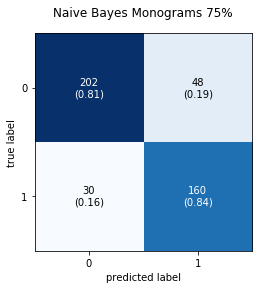

In [0]:
import matplotlib.pyplot as plt
multiclass = np.array([[202, 48, ],
                       [30, 160]])


fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=True
                                )
plt.title('Naive Bayes Monograms 75%')
plt.show()

# SUPPORT VECTOR MACHINE

In [0]:
#grid search
import numpy as np
from sklearn.model_selection import GridSearchCV
grid={"C":[0,0.5,1,1.5], "kernel":["linear","poly","sigmoid"],"gamma":['scale','auto']}
SVM=svm.SVC()
SVM_cv=GridSearchCV(SVM,grid,cv=10)
SVM_cv.fit(Train_X_Tfidf,Train_Y)



In [0]:
print("tuned hpyerparameters :(best parameters) ", SVM_cv.best_params_)
print("accuracy :",SVM_cv.best_score_)

tuned hpyerparameters :(best parameters) {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
accuracy : 82.4848484848485


In [0]:
# Classifier - Algorithm - SVM
# Fit the training dataset on the classifier
SVM = svm.SVC(C=0.5, kernel='linear', gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# Predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  85.0


In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions_SVM, Test_Y))

[[200  34]
 [ 32 174]]


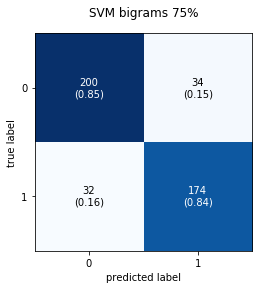

In [0]:
multiclass = np.array([[200, 34, ],
                       [32, 174,]])


fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=True
                                )
plt.title('SVM bigrams 75%')
plt.show()